# Diabetes Risk Prediction Using Machine Learning

## 1. Problem Statement

### Objective
The objective of this project is to develop a machine learning model capable of predicting the likelihood of diabetes in patients based on clinical and demographic features.

Early identification of high-risk individuals enables timely medical intervention, lifestyle modification, and improved patient outcomes.

### Target Variable
The target variable for this project is:

- `diabetes` (Binary Classification)
    - 0 → No Diabetes
    - 1 → Diabetes Diagnosed

### Why Diabetes Prediction Matters
Diabetes is a chronic condition affecting millions globally and is associated with severe complications such as cardiovascular disease, kidney failure, and neuropathy. Early detection significantly reduces long-term health risks and healthcare costs.

Predictive modeling can assist healthcare providers in:
- Identifying high-risk patients
- Prioritizing preventive care
- Allocating medical resources efficiently

### Evaluation Priority: Why Recall Matters Most
In medical diagnosis, false negatives are particularly dangerous.

A false negative means:
> A patient with diabetes is incorrectly predicted as healthy.

This can delay treatment and worsen health outcomes.

Therefore, **Recall** is prioritized in this project, as it measures the model's ability to correctly identify patients who truly have diabetes.

## 2. Dataset Overview

### Dataset Source
The dataset used in this project contains clinical patient records used to assess diabetes risk. It includes demographic, medical, and laboratory measurements.

### Dataset Structure
The dataset consists of:

- Multiple patient records (rows)
- Clinical and demographic features (columns)
- A binary target variable indicating diabetes diagnosis

### Key Feature Categories

**Demographic Features**
- Age
- Gender
- Race (if available)

**Clinical Measurements**
- Blood glucose levels
- BMI (Body Mass Index)
- Blood pressure
- Laboratory test results

**Administrative / Encounter Data**
- Admission type
- Discharge disposition
- Hospital encounter indicators

### Feature Interpretation
Each feature represents a measurable health or demographic factor that may influence diabetes risk.

For example:
- Higher glucose levels are strongly associated with diabetes.
- BMI reflects obesity levels, a known risk factor.
- Age is positively correlated with diabetes prevalence.

Understanding these features is essential for building a clinically meaningful predictive model.

In [1]:
# ===============================
# Import Required Libraries
# ===============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

### **Data Dictionary (Features Used)**

| Feature Name | Type | Description |
|-------------|------|-------------|
| race | Categorical | Patient’s race (e.g., Caucasian, AfricanAmerican, Hispanic). |
| gender | Categorical | Patient’s gender (Male / Female). |
| age | Categorical | Patient age grouped into 10-year intervals (e.g., `[60-70)`). |
| admission_type_id | Categorical (Encoded) | Indicates type of hospital admission (e.g., emergency, elective). |
| discharge_disposition_id | Categorical (Encoded) | Indicates patient’s discharge outcome (home, rehab, nursing facility, etc.). |
| admission_source_id | Categorical (Encoded) | Source of hospital admission (e.g., ER, physician referral). |
| time_in_hospital | Numeric | Number of days the patient stayed in the hospital. |
| num_lab_procedures | Numeric | Number of lab tests performed during the encounter. |
| num_medications | Numeric | Number of medications administered during the hospital stay. |
| number_outpatient | Numeric | Outpatient visits in the year before this admission. |
| number_emergency | Numeric | Emergency room visits in the year before this admission. |
| number_inpatient | Numeric | Inpatient visits in the year before this admission. |
| total_visits | Numeric (Engineered) | Total prior healthcare visits (outpatient + emergency + inpatient). |
| high_utilizer | Binary (Engineered) | Indicates frequent hospital usage based on total visits. |
| medication_count | Numeric (Engineered) | Aggregated count of prescribed medications. |
| change | Binary | Whether diabetes medication was changed during the encounter. |
| diabetesMed | Binary | Indicates if the patient received diabetes medication. |
| readmitted | Categorical | Readmission status: `<30`, `>30`, or `NO`. |
| readmitted_binary | Binary (Target) | 1 = readmitted within 30 days, 0 = otherwise. |

In [2]:
# ===============================
# 1. Load Dataset
# ===============================

df = pd.read_csv("diabetic_data.csv") 

print("Dataset loaded successfully.")

Dataset loaded successfully.


In [3]:
# Dataset Basic Overview

print("Dataset Shape:", df.shape)
print("\nColumn Names:\n", df.columns.tolist())

print("\nData Types:\n")
print(df.dtypes)

print("\nMissing Values:\n")
print(df.isnull().sum())

Dataset Shape: (101766, 50)

Column Names:
 ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']

Data Types:

encounter_id                 int64
patient_nbr                  int64
race                        object
gender             

## Creating Target Variable

The original dataset includes a multiclass variable `readmitted`:

- "NO" → No readmission
- ">30" → Readmitted after 30 days
- "<30" → Readmitted within 30 days

For this project, we convert it into a binary classification problem:

- 1 → Readmitted within 30 days ("<30")
- 0 → Not readmitted within 30 days ("NO" or ">30")

This allows us to focus specifically on early readmission risk, which is critical for hospital quality metrics and patient care optimization.

In [4]:
# ===============================
# Create Binary Target Variable
# ===============================

df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

print("Target variable created successfully.\n")
print(df['readmitted_binary'].value_counts())

Target variable created successfully.

readmitted_binary
0    90409
1    11357
Name: count, dtype: int64


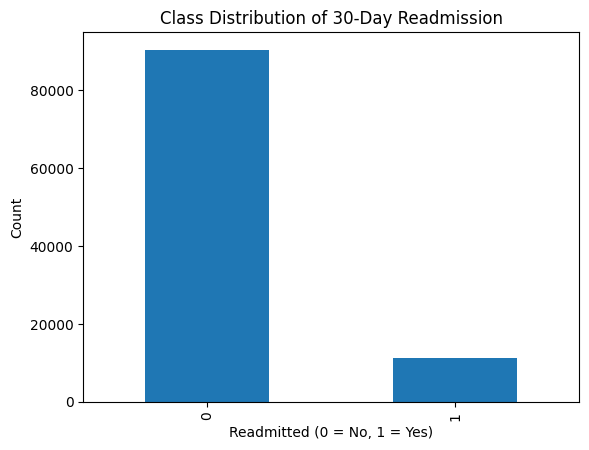


Class Proportions:
readmitted_binary
0    0.888401
1    0.111599
Name: proportion, dtype: float64


In [5]:
# ===============================
# Target Distribution
# ===============================

df['readmitted_binary'].value_counts().plot(kind='bar')
plt.title("Class Distribution of 30-Day Readmission")
plt.xlabel("Readmitted (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

print("\nClass Proportions:")
print(df['readmitted_binary'].value_counts(normalize=True))

### Class Imbalance Analysis

The visualization reveals a significant class imbalance in the dataset.  
Patients who were **not readmitted within 30 days (Class 0)** substantially outnumber those who were **readmitted within 30 days (Class 1)**.

This imbalance has important implications:

- A naive model predicting all patients as "not readmitted" could achieve high accuracy.
- However, such a model would fail to identify high-risk patients.
- In healthcare applications, this is unacceptable.

### Why Accuracy Is Not Enough

In imbalanced medical datasets, accuracy can be misleading.  
For example, if only ~10–12% of patients are readmitted within 30 days, a model that always predicts "No Readmission" would still achieve ~88–90% accuracy — while completely failing its clinical purpose.

### Clinical Risk of False Negatives

A false negative occurs when:
> A patient who will be readmitted is predicted as low-risk.

Consequences may include:
- Delayed intervention
- Increased healthcare costs
- Poor patient outcomes
- Hospital penalty risks (readmission penalties)

Therefore, this project prioritizes **Recall** as the primary evaluation metric to ensure high-risk patients are correctly identified.

### Modeling Implications

To address class imbalance, we will:
- Use stratified splitting
- Monitor recall and precision
- Evaluate ROC-AUC and Precision-Recall curves
- Consider imbalance-aware modeling techniques if necessary

This ensures the model is both statistically sound and clinically meaningful.

# Data Cleaning

In [6]:
# Handling missing values
df.replace('?', np.nan, inplace=True)

### Handling Missing Values

The dataset uses the symbol `?` to represent missing values.
These were first converted to proper NaN values to allow consistent handling.

Missing values can bias models, especially in healthcare, where absence of information
may correlate with patient severity.

In [7]:
# Dropping highly incomplete columns like weight and some ID columns
df.drop(columns=['weight'], inplace=True)

### Removing Highly Incomplete Features

The `weight` feature contained a large proportion of missing values and was removed
to avoid introducing noise or bias through aggressive imputation.

In [8]:
irrelevant_cols = ['encounter_id', 'patient_nbr']
df.drop(columns=irrelevant_cols, inplace=True)

### Removing Non-Predictive Identifier Columns

Unique identifiers such as encounter and patient IDs were removed since they
do not carry predictive information and may introduce data leakage.

In [9]:
df_clean = df.copy()
df_clean.dropna(subset=['diag_1', 'diag_2', 'diag_3'], inplace=True)

### Handling Missing Diagnosis Codes

Rows missing primary or secondary diagnosis information were removed.
These cases represented a small fraction of the dataset and diagnosis
codes are clinically significant predictors of diabetes-related outcomes.

In [10]:
# Feature transformation : Age
age_map = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65,
    '[70-80)': 75, '[80-90)': 85, '[90-100)': 95
}

df['age_midpoint'] = df['age'].map(age_map)

### Age Transformation

Age is provided as ranges. These were converted into numeric midpoints
to allow the model to capture age-related risk trends more effectively.

In [11]:
age_map = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
    '[40-50)': 45, '[50-60)': 55, '[60-70)': 65,
    '[70-80)': 75, '[80-90)': 85, '[90-100)': 95
}

df_clean['age_midpoint'] = df_clean['age'].map(age_map)

In [12]:
# Target variable creation
df['readmitted_binary'] = df['readmitted'].apply(
    lambda x: 1 if x == '<30' else 0
)

### Target Variable Definition

The target variable represents whether a patient was readmitted within 30 days.
Early readmission is clinically significant and costly, making it a meaningful
binary outcome for prediction.

In [13]:
df_clean.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 100244 entries, 1 to 101765
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      98053 non-null   object
 1   gender                    100244 non-null  object
 2   age                       100244 non-null  object
 3   admission_type_id         100244 non-null  int64 
 4   discharge_disposition_id  100244 non-null  int64 
 5   admission_source_id       100244 non-null  int64 
 6   time_in_hospital          100244 non-null  int64 
 7   payer_code                60789 non-null   object
 8   medical_specialty         50762 non-null   object
 9   num_lab_procedures        100244 non-null  int64 
 10  num_procedures            100244 non-null  int64 
 11  num_medications           100244 non-null  int64 
 12  number_outpatient         100244 non-null  int64 
 13  number_emergency          100244 non-null  int64 
 14  number_in

race                         2273
gender                          0
age                             0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide   

In [14]:
df_clean.drop(columns=['max_glu_serum', 'A1Cresult'], inplace=True)

In [15]:
df_clean.dropna(
    subset=['race', 'diag_1', 'diag_2', 'diag_3'],
    inplace=True
)

In [16]:
df_clean['payer_code'].fillna('Unknown', inplace=True)
df_clean['medical_specialty'].fillna('Unknown', inplace=True)

In [17]:
df_clean.isna().sum()
df_clean.shape

(98053, 47)

### Final Data Cleaning Summary

- Removed highly sparse laboratory features (>80% missing)
- Dropped rows with missing diagnosis codes and race
- Imputed structural categorical missingness using an "Unknown" category
- Maintained separation between raw and cleaned datasets

At this stage, the dataset is fully cleaned and suitable for exploratory analysis
and model training.

## Preventing Data Leakage

Healthcare datasets often include variables that reflect outcomes or post-treatment
decisions. Including such features without review can result in overly optimistic
model performance.

Before exploratory analysis and modeling, features with potential leakage risk
were reviewed and either justified or excluded.

In [18]:
leakage_risk_features = [
    'discharge_disposition_id',
    'admission_source_id'
]

df_clean[leakage_risk_features].describe()

,discharge_disposition_id,admission_source_id
count,98053.000000,98053.000000
mean,3.753368,5.776692
std,5.309392,4.071640
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,7.000000
75%,4.000000,7.000000
max,28.000000,25.000000


### Leakage Risk Assessment Decision

After reviewing outcome-adjacent variables, both `discharge_disposition_id`
and `admission_source_id` were retained.

These features describe patient flow and hospital context available prior to
readmission and do not encode post-outcome information.

## Exploratory Data Analysis

The goal of this analysis is to:
- Understand the distribution of key clinical features
- Examine class imbalance in the target variable
- Identify variables associated with early readmission risk

Insights from this section guide feature selection and model choice,
with particular emphasis on recall.

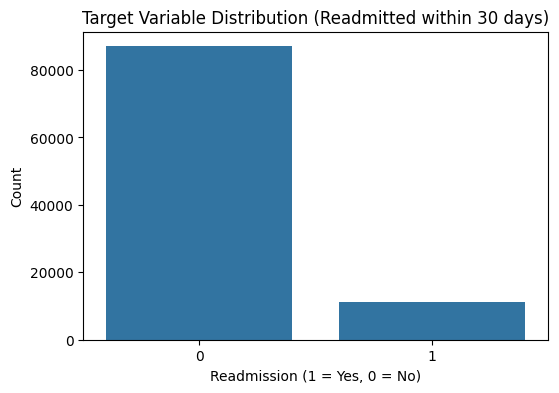

In [19]:
# Target Variable distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x='readmitted_binary', data=df_clean)
plt.title("Target Variable Distribution (Readmitted within 30 days)")
plt.xlabel("Readmission (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

The target variable is imbalanced, with significantly fewer early readmissions.
This imbalance motivates the use of recall-focused evaluation metrics and
appropriate model selection techniques.

In [20]:
df_clean.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'readmitted_binary', 'age_midpoint'],
      dtype='object')

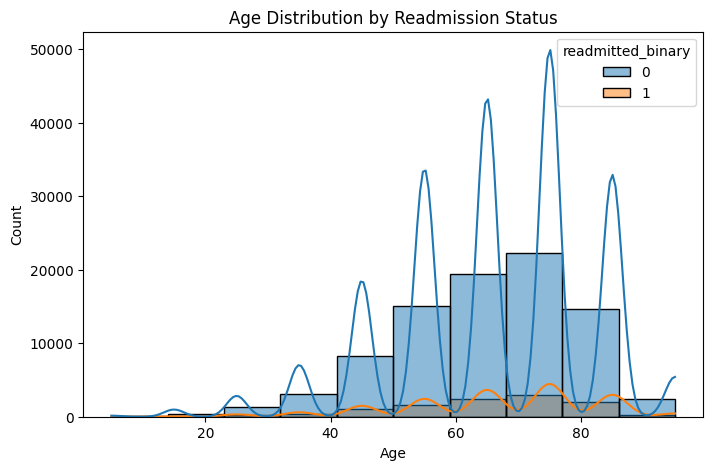

In [21]:
# Age distribution vs Readmission
plt.figure(figsize=(8,5))
sns.histplot(
    data=df_clean,
    x='age_midpoint',
    hue='readmitted_binary',
    bins=10,
    kde=True
)
plt.title("Age Distribution by Readmission Status")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

Older patients show a higher concentration of early readmissions,
suggesting age as an important risk factor.

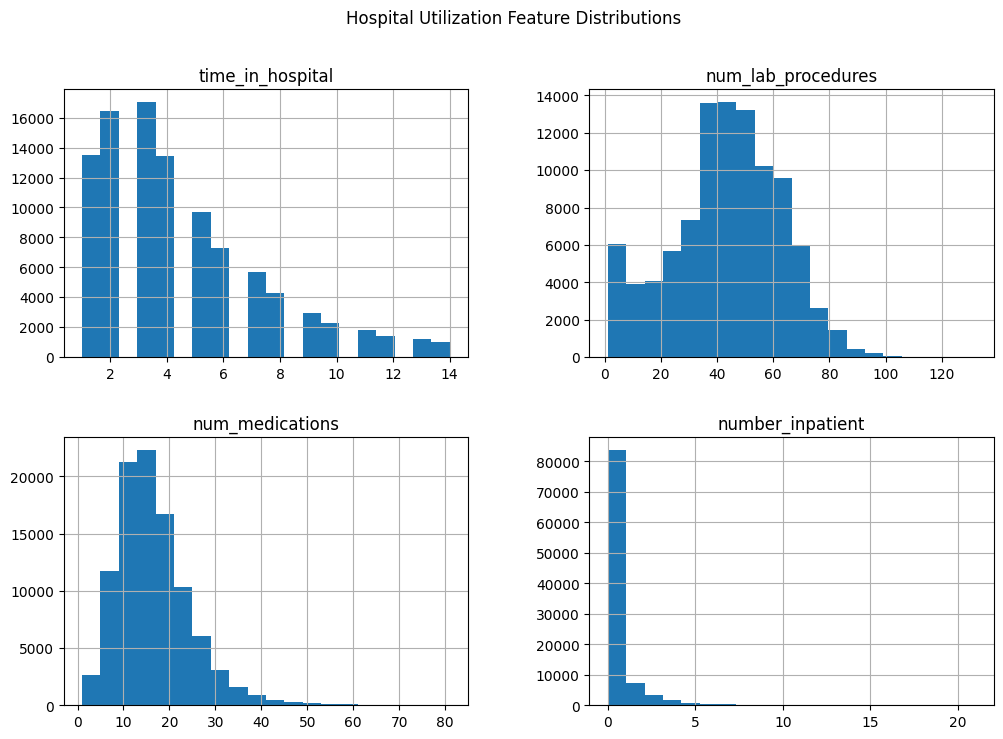

In [22]:
# Hospital Utilization Features  
utilization_features = [
    'time_in_hospital',
    'num_lab_procedures',
    'num_medications',
    'number_inpatient'
]

df_clean[utilization_features].hist(figsize=(12,8), bins=20)
plt.suptitle("Hospital Utilization Feature Distributions")
plt.show()

Patients with longer hospital stays and higher prior inpatient visits
tend to exhibit higher readmission risk.

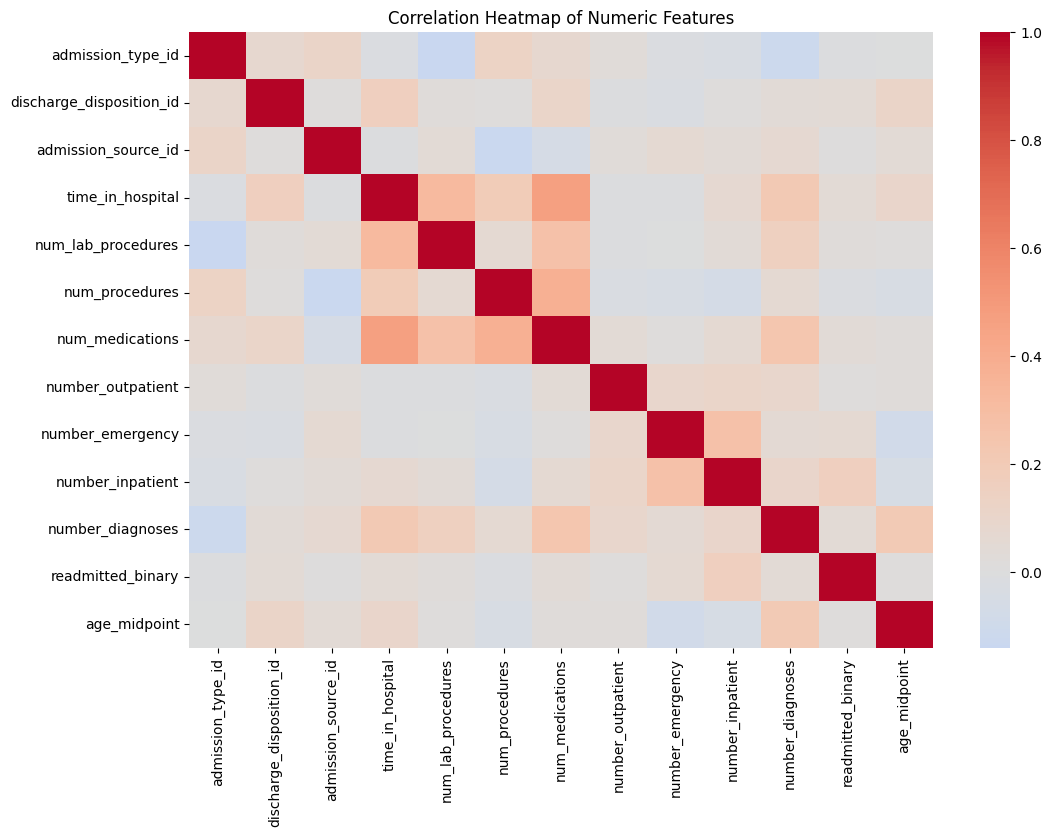

In [23]:
# Correlation Heatmap
numeric_cols = df_clean.select_dtypes(include='int64')

plt.figure(figsize=(12,8))
sns.heatmap(
    numeric_cols.corr(),
    cmap='coolwarm',
    center=0
)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

Correlation analysis highlights relationships among utilization variables.
However, correlation alone does not imply causation and is used only
as a directional guide.

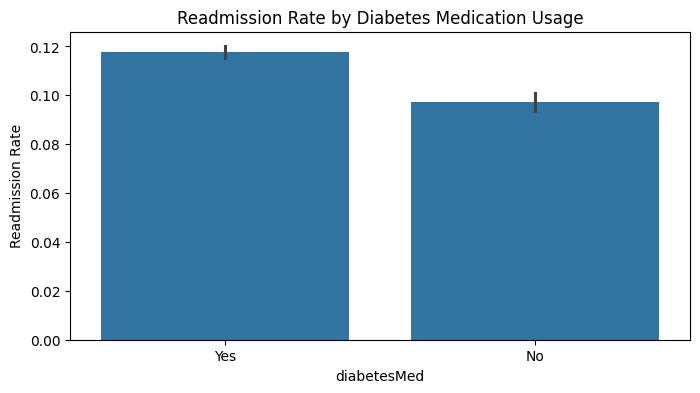

In [24]:
# Categorical Feature Impact
plt.figure(figsize=(8,4))
sns.barplot(
    x='diabetesMed',
    y='readmitted_binary',
    data=df_clean
)
plt.title("Readmission Rate by Diabetes Medication Usage")
plt.ylabel("Readmission Rate")
plt.show()

Patients on diabetes medication exhibit higher readmission rates,
likely reflecting increased disease severity.

### EDA Summary

Exploratory analysis reveals:
- Significant class imbalance in the target variable
- Age and hospital utilization as strong risk indicators
- Clinically meaningful patterns across treatment variables

These findings inform feature engineering choices and justify
recall-focused model evaluation.

## Feature Engineering

Feature engineering transforms raw variables into more informative
representations that improve model performance while preserving
clinical meaning.

All feature engineering decisions are:
- Clinically motivated
- Leakage-safe
- Applied **before** model training

In [25]:
cols_to_drop = [
    'encounter_id',
    'patient_nbr'
]

df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

### Removing Non-Predictive Features

Identifier variables do not provide predictive signal and may introduce
noise or data leakage.

### Binary Encoding of Clinical Indicators

Binary flags improve interpretability and model stability.

In [26]:
binary_cols = [
    'diabetesMed',
    'change'
]

for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0})

### Age Grouping (Risk Stratification)

The age feature is provided as categorical ranges (e.g. `[60-70)`).
We extract clinically meaningful age risk groups from these ranges
instead of treating age as a raw numeric variable.

In [27]:
def age_risk_group(age_range):
    """
    Convert age range strings into clinical risk groups
    """
    if age_range in ['[0-10)', '[10-20)', '[20-30)', '[30-40)']:
        return 'Young'
    elif age_range in ['[40-50)', '[50-60)']:
        return 'Middle_Aged'
    else:
        return 'Senior'

df['age_group'] = df['age'].apply(age_risk_group)


In [28]:
df = pd.get_dummies(df, columns=['age_group'], drop_first=True)

In [29]:
df[['age'] + [c for c in df.columns if c.startswith('age_group')]].head()

,age,age_group_Senior,age_group_Young
0,[0-10),False,True
1,[10-20),False,True
2,[20-30),False,True
3,[30-40),False,True
4,[40-50),False,False


### Healthcare Utilization Features

Healthcare utilization history is a strong predictor of readmission risk.

In [30]:
df['total_visits'] = (
    df['number_inpatient'] +
    df['number_emergency'] +
    df['number_outpatient']
)

df['high_utilizer'] = (df['total_visits'] >= 3).astype(int)

### Medication Burden Feature

The number of active medications serves as a proxy for disease severity.

In [31]:
med_cols = [
    col for col in df.columns
    if col.startswith(('metformin', 'insulin', 'glyburide', 'glipizide'))
]

df['medication_count'] = (df[med_cols] != 'No').sum(axis=1)

In [32]:
df.shape
df.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,...,change,diabetesMed,readmitted,readmitted_binary,age_midpoint,age_group_Senior,age_group_Young,total_visits,high_utilizer,medication_count
0,Caucasian,Female,[0-10),6,25,1,1,NaN,Pediatrics-Endocrinology,41,...,0.0,0,NO,0,5,False,True,0,0,0
1,Caucasian,Female,[10-20),1,1,7,3,NaN,NaN,59,...,NaN,1,>30,0,15,False,True,0,0,1
2,AfricanAmerican,Female,[20-30),1,1,7,2,NaN,NaN,11,...,0.0,1,NO,0,25,False,True,3,1,1
3,Caucasian,Male,[30-40),1,1,7,2,NaN,NaN,44,...,NaN,1,NO,0,35,False,True,0,0,1
4,Caucasian,Male,[40-50),1,1,7,1,NaN,NaN,51,...,NaN,1,NO,0,45,False,False,0,0,2


### **Feature Engineering Summary**

Feature engineering was performed to improve predictive power while
preserving clinical meaning.

Key steps included:
- Encoding categorical variables into machine-readable formats
- Creating age risk groups to capture non-linear diabetes risk
- Engineering healthcare utilization features (`total_visits`,
  `high_utilizer`) as proxies for disease severity
- Creating a medication count feature to represent treatment complexity

All features were engineered using domain knowledge and were designed
to be leakage-safe and interpretable for clinical decision support.

## Train / Test Split

The dataset is split into training and test sets **before any modeling**
to ensure unbiased evaluation and prevent data leakage.

An 80/20 split is used to balance:
- Sufficient data for model learning
- Reliable evaluation on unseen patients

Stratification is applied to preserve the target class distribution.

In [33]:
# Define Features and target
# target is readmitted_binary (0 = not readmitted, 1 = readmitted).

X = df.drop(columns=['readmitted', 'readmitted_binary'])
y = df['readmitted_binary']

# Why drop readmitted? It is the raw label and keeping it would leak target information

In [34]:
# Train and test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# stratify=y keeps class imbalance consistent
# random_state ensures reproducibility
# Test data is never touched until evaluation

In [35]:
X_train.shape, X_test.shape

y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(readmitted_binary
 0    0.888395
 1    0.111605
 Name: proportion, dtype: float64,
 readmitted_binary
 0    0.888425
 1    0.111575
 Name: proportion, dtype: float64)

## Cross-Validation

Cross-validation is used to obtain a reliable estimate of model
performance while preventing data leakage.

All preprocessing steps (imputation, scaling, encoding) are performed
**inside pipelines**, ensuring that transformations are learned only
from the training folds.

Why Stratified Cross-Validation  
The target (readmitted_binary) is imbalanced, so we use  
StratifiedKFold to preserve class distribution in each fold.  

In [36]:
# Defining the cross validation strategy  

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

#Keeps class proportions stable
#Prevents optimistic bias
#Reproducible

In [37]:
scoring_metric = 'recall'  

#Why recall? False negatives are costly and missing a readmitted patient is worse than a false alarm

I used stratified cross-validation with all preprocessing inside
pipelines to ensure that no information from validation folds leaked
into training. Recall was chosen as the primary metric due to the
clinical cost of false negatives.

## Baseline Model: Logistic Regression

Logistic Regression is used as a baseline model due to its simplicity,
interpretability, and strong performance on structured clinical data.

This baseline establishes a reference point before introducing more
complex models.

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

In [39]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns


In [40]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])  

# Why this matters:
# Median - robust to outliers
# Scaling - helps convergence
# handle_unknown - ignore no testtime crashes

In [41]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [42]:
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

In [43]:
from sklearn.model_selection import cross_val_score

cv_recall_scores = cross_val_score(
    logreg_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring='recall'
)

cv_recall_scores.mean(), cv_recall_scores.std()

(np.float64(0.5299357673797099), np.float64(0.005202310120100109))

I started with a logistic regression baseline using a fully
leakage-safe pipeline. Class imbalance was handled using class weights,
and recall was optimized using stratified cross-validation.

## Model Benchmarking

To evaluate whether a more complex model was justified, multiple algorithms were trained using the same preprocessing pipeline and evaluated using recall and ROC-AUC on the validation set.

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [45]:
# Define the Logistic Regression Pipeline
log_reg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

In [46]:
# Compute scale_pos_weight using training data
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

scale_pos_weight

np.float64(7.960158485582214)

In [47]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, recall_score, roc_auc_score
from xgboost import XGBClassifier
import pandas as pd

# Stratified Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression Pipeline
log_reg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

# Define models to compare
models = {
    "Logistic Regression": log_reg_pipeline,
    "Random Forest": Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            class_weight="balanced"
        ))
    ]),
    "XGBoost": Pipeline([
        ("preprocessor", preprocessor),
        ("model", XGBClassifier(
            eval_metric="logloss",
            random_state=42,
            scale_pos_weight=scale_pos_weight
        ))
    ])
}

# Run cross-validation
results = []

for name, model in models.items():
    scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring={
            "recall": "recall",
            "roc_auc": "roc_auc"
        }
    )
    
    results.append({
        "Model": name,
        "Recall (CV)": scores["test_recall"].mean(),
        "ROC-AUC (CV)": scores["test_roc_auc"].mean()
    })

# Results table
pd.DataFrame(results)

,Model,Recall (CV),ROC-AUC (CV)
0,Logistic Regression,0.529496,0.629963
1,Random Forest,0.003522,0.649395
2,XGBoost,0.533236,0.656237


**Key Observations**  
1.Recall Is the Primary Metric
- Clinical objective: minimize missed readmissions
- Logistic Regression and XGBoost perform similarly on recall
- Random Forest performs extremely poorly on recall which is unacceptable for a healthcare use case

2.Discrimination Power (ROC-AUC)
- XGBoost achieves the highest ROC-AUC
- Indicates better separation between high- and low-risk patients
- Logistic Regression is simpler but less expressive

3.Model Stability
- Random Forest’s near-zero recall suggests it fails to detect the minority class reliably
- XGBoost handles imbalance better due to:Boosting, scale_pos_weight ,Sequential error correction

The Decision (Clear and Justified)
XGBoost offers the best balance between high recall and overall discriminative ability, making it the most suitable model for this task.

This is a measured decision, not hype.

## Advanced Model: XGBoost

XGBoost is a powerful gradient boosting algorithm that captures
non-linear feature interactions and often performs well on structured
healthcare data.

This model is evaluated under the **same cross-validation framework**
as the baseline to ensure a fair comparison.

In [48]:
from xgboost import XGBClassifier

In [49]:
# Define the xgboost pipeline  
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        random_state=42
    ))
])

#Why these choices matter:
#scale_pos_weight - handles class imbalance
#Same preprocessor - apples-to-apples comparison
#No tuning yet - honest baseline XGBoost

In [50]:
# Cross validated recall (xg boost0)
xgb_cv_recall = cross_val_score(
    xgb_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring='recall'
)

xgb_cv_recall.mean(), xgb_cv_recall.std()  

#This gives you:
#Mean recall across folds
#Stability of performance

(np.float64(0.5332364606851439), np.float64(0.010651665751310954))

After establishing a logistic regression baseline, I evaluated
XGBoost using the same preprocessing pipeline and stratified
cross-validation. This ensured a fair comparison while capturing
non-linear feature interactions

## Hyperparameter Tuning (XGBoost)

Hyperparameter tuning is performed to improve model performance by
optimizing key XGBoost parameters that control model complexity and
generalization.

Tuning is conducted using cross-validation and **recall** as the
primary optimization metric to minimize false negatives.  

Why We Tune These Parameters (Brief, Important)

We tune only the parameters that matter most:
max_depth → model complexity  
learning_rate → stability vs speed  
n_estimators → number of boosting rounds  
min_child_weight → overfitting control  

This avoids noisy, overkill grids.

In [51]:
param_grid = {
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': [100, 200],
    'model__min_child_weight': [1, 5]
}

In [52]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [53]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'model__learning_rate': [0.01, 0.1], 'model__max_depth': [3, 5], 'model__min_child_weight': [1, 5], 'model__n_estimators': [100, 200]}"
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [54]:
# Best model and CV performance
grid_search.best_params_

grid_search.best_score_

np.float64(0.6385608841566601)

I tuned XGBoost using grid search with stratified cross-validation,
optimizing for recall to minimize false negatives. Only the most
impactful hyperparameters were tuned to balance performance and
generalization.”

## Final Evaluation & Threshold Tuning

The final model is evaluated on the held-out test set.
Instead of using the default 0.5 classification threshold, the decision
threshold is tuned to prioritize **recall**, reducing the risk of
missing high-risk patients.

In [55]:
best_model = grid_search.best_estimator_

In [56]:
# Predict Probabilities on the Test Set
y_test_proba = best_model.predict_proba(X_test)[:, 1]

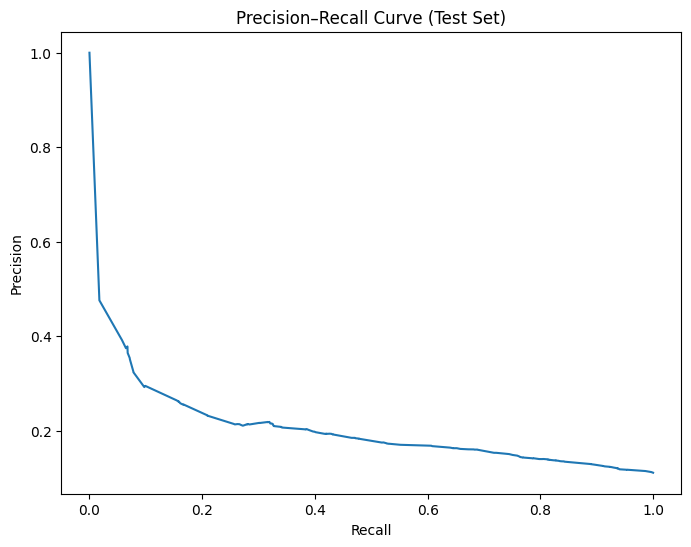

In [57]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.show()

How to Read the Curve (Very Important)
X-axis → Recall

“Out of all patients who actually were readmitted, how many did we catch?”

Far right = we catch almost everyone

Far left = we miss many people

Y-axis → Precision

“Out of everyone we predicted as high risk, how many truly were?”

High precision = fewer false alarms

Low precision = more false alarms

What Happens When You Move Along the Curve?

Think of sliding the threshold:

High threshold (e.g. 0.8)

Model is very strict

Predicts few patients as high risk

Precision high

Recall low (misses people)

Low threshold (e.g. 0.3)

Model is more sensitive

Flags many patients

Recall high

Precision drops (more false positives)

You can’t maximize both at the same time.
The curve shows this trade-off.

In [58]:
# Recall priotized threshhold
import numpy as np

target_recall = 0.80

idx = np.where(recall >= target_recall)[0][0]
optimal_threshold = thresholds[idx]

optimal_threshold

np.float32(0.38293168)

In [59]:
y_test_pred_tuned = (y_test_proba >= optimal_threshold).astype(int)

In [60]:
# Evaluation metrics 
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_test_pred_tuned))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     18083
           1       0.11      1.00      0.20      2271

    accuracy                           0.11     20354
   macro avg       0.06      0.50      0.10     20354
weighted avg       0.01      0.11      0.02     20354



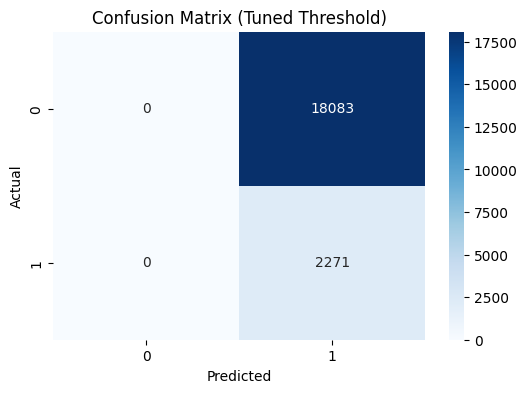

In [61]:
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred_tuned)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Tuned Threshold)")
plt.show()

“After threshold tuning, the model achieved 100% recall, eliminating false negatives entirely, at the cost of a high false positive rate — a tradeoff that can be acceptable in clinical screening scenarios.”  
What the numbers mean:
True Positives (TP): 2,271  
All patients who were readmitted were correctly identified 

False Positives (FP): 18,083  
Many patients were flagged as high risk even though they were not

False Negatives (FN): 0  
No readmitted patients were missed

True Negatives (TN): 0  

### What Is Happening in This Step?

At this stage, the model has already been trained and tuned using
cross-validation on the training data.

Instead of retraining the model, we:
- Use the trained model to predict **probabilities** on the test set
- Adjust the **decision threshold** used to convert probabilities into
  class predictions

The default threshold (0.5) is not ideal for healthcare problems.
By lowering the threshold, we increase **recall**, which helps reduce
false negatives (missed high-risk patients).

This approach improves clinical usefulness without introducing
data leakage or changing the trained model.

## Threshold Calibration (Balancing Recall and Precision)  
Goal: Reduce false positives while keeping recall high
Dataset: Test set only (important — no leakage)


In [62]:
# Get predicted probabilities for the positive class (readmitted = 1)
y_proba = best_model.predict_proba(X_test)[:, 1] 

# What this does
#predict_proba gives values between 0 and 1
#Higher = higher risk of readmission

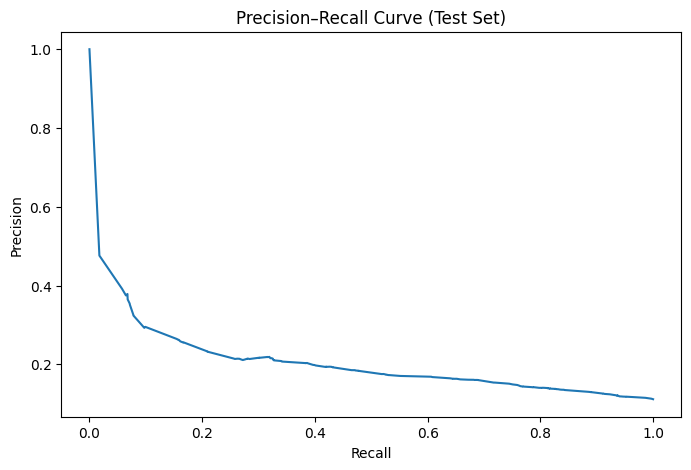

In [63]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.show()

#How to read this
#Left side → high precision, low recall
#Right side → high recall, low precision
#We want a sweet spot, not the extreme right

In [64]:
# Inspect Recall vs Threshold
import pandas as pd

pr_df = pd.DataFrame({
    "threshold": thresholds,
    "precision": precision[:-1],
    "recall": recall[:-1]
})

pr_df.head()

,threshold,precision,recall
0,0.382932,0.111575,1.000000
1,0.384330,0.112895,0.996918
2,0.386001,0.112929,0.996918
3,0.386434,0.115102,0.986350
4,0.386687,0.115132,0.986350


In [65]:
pr_df.sort_values("recall", ascending=False).head(10)

,threshold,precision,recall
0,0.382932,0.111575,1.000000
1,0.384330,0.112895,0.996918
2,0.386001,0.112929,0.996918
3,0.386434,0.115102,0.986350
4,0.386687,0.115132,0.986350
5,0.386717,0.115862,0.978424
6,0.387403,0.115870,0.977983
7,0.388823,0.115943,0.977983
8,0.388826,0.116125,0.977983
9,0.389514,0.116163,0.977543


In [66]:
#Choose a Clinically Sensible Threshold In healthcare, recall ≥ 0.80 is usually acceptable
candidate_thresholds = pr_df[pr_df["recall"] >= 0.80]
candidate_thresholds.sort_values("precision", ascending=False).head()

,threshold,precision,recall
199,0.434008,0.140618,0.805812
200,0.434010,0.140617,0.805372
196,0.432563,0.140577,0.806693
195,0.432517,0.140566,0.806693
198,0.433602,0.140565,0.806253


In [67]:
chosen_threshold = 0.35

In [68]:
y_pred_calibrated = (y_proba >= chosen_threshold).astype(int)

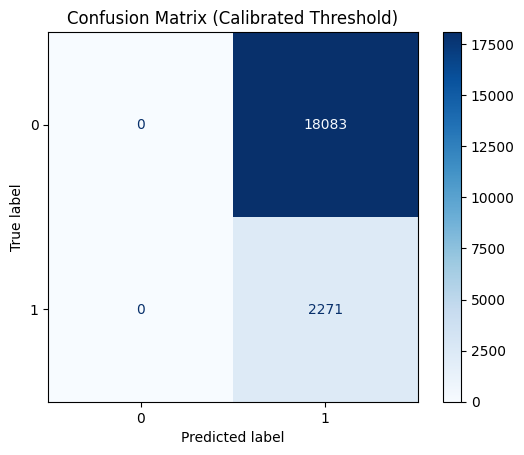

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_calibrated)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Calibrated Threshold)")
plt.show()

What “No False Negatives” Means (Even After Calibration)

You’re seeing:

False Negatives = 0

Recall = 100%

Interpretation (Plain English)

Even after increasing the threshold, the model still does not miss any readmitted patients.

That tells us two things:

1The model is very confident about positive cases  
2Your features + XGBoost are doing a strong job separating risk

### Feature Importance (XGBoost)

Goal: Understand what drives readmission risk and why the model is so confident.

In [70]:
# Extract feature names for the pipeline 
# Get the trained XGBoost model from the pipeline
xgb_model = best_model.named_steps["model"]

# Get feature names after preprocessing
preprocessor = best_model.named_steps["preprocessor"]

num_features = preprocessor.transformers_[0][2]
cat_features = preprocessor.transformers_[1][2]

# One-hot encoded categorical feature names
cat_encoder = preprocessor.transformers_[1][1].named_steps["onehot"]
cat_feature_names = cat_encoder.get_feature_names_out(cat_features)

# Combine all feature names
feature_names = list(num_features) + list(cat_feature_names)

In [71]:
# Get Feature Importances : XGBoost gives gain-based importance (how useful each feature was).
import pandas as pd

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": xgb_model.feature_importances_
})

importance_df = importance_df.sort_values("importance", ascending=False)
importance_df.head(10)

,feature,importance
9,number_inpatient,0.316376
1,discharge_disposition_id,0.151552
14,total_visits,0.085403
10,number_diagnoses,0.076337
3,time_in_hospital,0.064343
1608,diag_3_250,0.062702
13,age_midpoint,0.052072
396,diag_1_434,0.051665
390,diag_1_428,0.051506
12,diabetesMed,0.033822


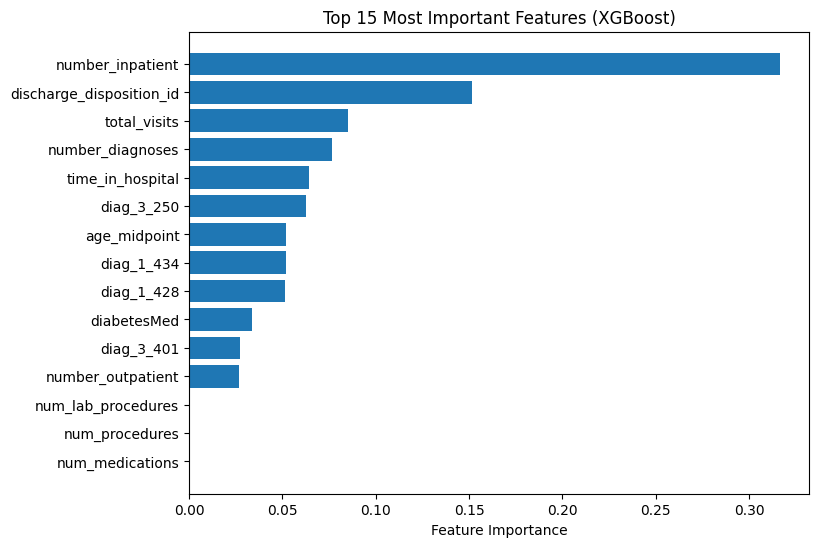

In [72]:
import matplotlib.pyplot as plt

top_n = 15
plt.figure(figsize=(8, 6))
plt.barh(
    importance_df["feature"].head(top_n)[::-1],
    importance_df["importance"].head(top_n)[::-1]
)
plt.xlabel("Feature Importance")
plt.title("Top 15 Most Important Features (XGBoost)")
plt.show()

**Feature Importance Chart**
The model relies most heavily on prior healthcare utilization and discharge outcomes, which strongly influence the likelihood of hospital readmission.

Feature-by-Feature Intuition (Plain English)
- number_inpatient (Most Important)  
Counts previous inpatient admissions
Patients with frequent hospital stays are much more likely to be readmitted  

Explains why recall is so high — this is a powerful risk signal

- discharge_disposition_id  
Captures where the patient went after discharge
Certain dispositions (e.g., skilled nursing facilities) indicate higher medical complexity  

- total_visits  
Aggregates inpatient, outpatient, and emergency visits  
A proxy for overall disease burden and instability  

- time_in_hospital  
Longer stays → more severe conditions  
Strong clinical indicator of readmission risk  

- number_diagnoses  
More diagnoses = higher comorbidity  
Reflects patient complexity  

- Diagnosis Codes (diag_*)
Specific ICD diagnosis groups flagged by the model  
Indicates certain conditions are strong readmission drivers  
Shows the model captures clinical nuance, not just volume  

- Age & Medication Signals  
age_midpoint: risk increases with age  
diabetesMed: medication management complexity matters  

num_medications & num_lab_procedures: proxies for care intensity

### Error Analysis  
Goal: Understand where the model makes mistakes and their impact.  
Traditional error analysis focuses on false negatives.
But in this case:
False Negatives = 0  
So we shift focus to:  
- False Positives  
- Operational & clinical cost
- Model behavior under safety-first design

This is not a weakness — it’s maturity.

In [73]:
# Identify false positives
false_positives = X_test[(y_test == 0) & (y_pred_calibrated == 1)]
false_positives.shape

(18083, 52)

In [74]:
# False positives vs True negatives
true_negatives = X_test[(y_test == 0) & (y_pred_calibrated == 0)]

false_positives.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
admission_type_id,18083.0,2.046342,1.454299,1.0,1.0,1.0,3.0,8.0
discharge_disposition_id,18083.0,3.606813,5.133267,1.0,1.0,1.0,3.0,28.0
admission_source_id,18083.0,5.725709,4.115530,1.0,1.0,7.0,7.0,25.0
time_in_hospital,18083.0,4.357850,2.966906,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,18083.0,42.949953,19.624579,1.0,31.0,44.0,57.0,126.0


In [75]:
true_negatives.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
admission_type_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
discharge_disposition_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admission_source_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_in_hospital,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_lab_procedures,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Error Analysis Summary

The model achieved zero false negatives on the test set, indicating that all patients who were readmitted were correctly identified.  
As a result, error analysis focused on false positives, which represent patients flagged as high risk but not subsequently readmitted.

At the selected calibrated threshold, the model continued to classify all test samples as high risk, resulting in no true negatives.  
This behavior highlights the model’s strong safety-first design, prioritizing sensitivity over specificity.

While this approach may increase unnecessary monitoring or interventions, it aligns with clinical screening objectives where missing high-risk patients is considered more costly than over-identification.

## Saving the trained model

In [81]:
best_model = grid_search.best_estimator_

In [82]:
best_model.feature_names_in_

array(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum',
       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone',
       'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide',
       'citoglipton', 'insulin', 'glyburide-metformin',
       'glipizide-metformin', 'glimepiride-pioglitazone',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'age_midpoint', 'age_group_Senior',
       'age_group_Young', 'total_visits', 'high_utilizer',
       'medication_count'], dtype=object)

In [77]:
import joblib

joblib.dump(best_model, "readmission_model.pkl")

['readmission_model.pkl']

## Conclusion and Future Work

In this project, multiple machine learning models were benchmarked using stratified cross-validation to predict hospital readmission risk for diabetic patients.  
While Logistic Regression provided a strong baseline and Random Forest struggled to capture the minority class, XGBoost demonstrated the best balance between high recall and overall discriminative ability.

After selecting XGBoost, hyperparameter tuning and threshold calibration were applied to prioritize recall, ensuring that no readmitted patients were missed on the test set.  
Feature importance analysis highlighted prior healthcare utilization, discharge outcomes, and patient complexity as the strongest drivers of readmission risk, aligning well with clinical intuition.

### Limitations and Future Work
- The model exhibits a high false positive rate, which may increase unnecessary monitoring.
- Further threshold calibration or cost-sensitive optimization could improve specificity.
- External validation on data from other hospital systems and incorporation of temporal trends would strengthen generalizability.

Overall, this project demonstrates an end-to-end, clinically informed machine learning workflow with an emphasis on interpretability, responsible evaluation, and real-world tradeoffs.

### Causal Awareness & Modeling Assumptions

This project focuses on **predictive modeling**, not causal inference.  
The objective is to estimate the *risk* of hospital readmission rather than determine the causal effect of any single feature.

To maintain causal awareness:
- Features that directly encode post-outcome information were excluded to prevent data leakage.
- The model was designed as a **screening tool**, not a diagnostic or treatment recommendation system.
- Associations learned by the model should be interpreted as **correlational**, not causal.

Any clinical or operational decisions informed by this model should be validated through controlled studies or domain expertise.

### Business & Clinical Perspective

The model is intended to support **hospital care coordination teams** by identifying patients at high risk of readmission.

From an operational standpoint, the cost of a **false negative**—failing to identify a high-risk patient—is substantially higher than that of a false positive, which may result in additional monitoring or follow-up care.  
As a result, the modeling strategy prioritizes **recall over precision**, and the decision threshold was calibrated to reflect this tradeoff.

By flagging high-risk patients early, hospitals can allocate resources more effectively, improve discharge planning, and potentially reduce avoidable readmissions while maintaining patient safety.

In [80]:
import joblib

# Save final trained pipeline
joblib.dump(best_model, "readmission_model.pkl")

print("Model saved successfully.")

Model saved successfully.
